# How to make a personal DJ in 5 simple steps

We set out to create a personal DJ that had the power to recommend create a curated party playlist for you. In order to do this, we needed to create a recommender system that could distinguish between a song that was "party" and a song that was "non-party" based off of audio featuers such as danceability, energy, valene, and tempo.

We accomplished this in 5 simple steps.
1) Setting out our Environment
2) Retrieving/Cleaning/Visualizing/Analyzing the data
3) Training Classification Models
4) Testing the Models
5) Choosing the best fit model and encapsulating the recommener in a DJ class

They might not sound so simple but in this notebook we try and break it down as best as possible.


Step 1: Setting out our Environment
To set up our environment we needed to do 2 main things, 1) import all necessary packages for data handling and machine learning and 2) Configure out Spotipy to allow us to retrieve music data using Spotify's WEB API.
Spotipy is a python wrapper for Spotify's Web API that allows you to easily retrieve music information. More info can be found here: https://spotipy.readthedocs.io/en/2.12.0/.

In [29]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [17]:
#Spotify API Setup
SPOTIPY_CLIENT_ID = "236e81909708434598e63e00fe671955"
SPOTIPY_CLIENT_SECRET = "5d574a1eb8f940b783b72b00c5eb4658"
cc = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=cc)

Step 2: Retrieving/Cleaning/Visualizing/Analyzing the data
In order to create a "DJ" that could recommend you party songs, we needed music data... a lot of music data. This seciton goes through the process of creating a pandas dataframe that retrieves hundreds of "party" songs that we classify as a party song by giving it a 1 and hundreds of non party songs that we classify as a non party song by giving it a 0. We then pass the models the audio features as featuers and the party as a target and train it to detect wheteher a song is "party" enough based off of its audio features. Before we can do that, we need to capture this information in a table that the model can read. 

In [18]:
#Create music dataframe of party songs and non party songs
columns = ["track_id", "song", "acousticness", "danceability", "energy",
            "instrumentalness", "liveness", "loudness", "speechiness",
            "valence", "tempo", "party"]
music = pd.DataFrame(columns=columns)

In [19]:
#Two playlists created by us that we populated with "party" and "non party songs"
#Here's the link to the party playlist we used: https://open.spotify.com/playlist/5ge2YqUbZrmqd2Mve8Uezf?si=m7ms4-EfQj6VFBsN5o-BbA
party_playlist_id = "5ge2YqUbZrmqd2Mve8Uezf?si=VVFB-RkdQMOpy1BffTeozQ"
#Here's the link for the non-party playlist we used: https://open.spotify.com/playlist/1vviyyoqxJyVpnNL4Cf6Xz?si=17SoNRa-RNuMVNG60DlWEg
non_party_playlist_id = "1vviyyoqxJyVpnNL4Cf6Xz?si=FtKKu3ICSaWPOY7st55HbQ"

In [20]:
def song_to_df(track_id, song_name, party):
    song_features = sp.audio_features(track_id)[0]
    song_data = {'track_id': track_id,
                 'song': song_name,
                 'acousticness': song_features.get("acousticness"),
                 'danceability': song_features.get("danceability"),
                 'energy': song_features.get("energy"),
                 'instrumentalness': song_features.get("instrumentalness"),
                 'liveness': song_features.get("liveness"),
                 'loudness': song_features.get("loudness"),
                 'speechiness': song_features.get("speechiness"),
                 'valence': song_features.get("valence"),
                 'tempo': song_features.get("tempo"),
                 'party': party
                }
    return song_data

In [21]:
def playlist_to_df(df, playlist_id, party):
    songs = sp.playlist_tracks(playlist_id).get("tracks").get("items")
    music_frame = df
    for song in songs:
        track = song.get("track")
        song_name = track.get("name")
        track_id = track.get("id")
        song_data = song_to_df(track_id, song_name, party)
        music_frame = music_frame.append(song_data, ignore_index=True)

        #In order to increase the size of our data pool, we utilize a feature from Spotifys Web API that gets 5 similar songs for every song
        recommendations = sp.recommendations(seed_tracks=[track_id], limit = 5).get("tracks")
        for recommendation in recommendations:
            r_song_name = recommendation.get("name")
            r_track_id = recommendation.get("id")
            r_song_data = song_to_df(r_track_id, r_song_name, party)
            music_frame = music_frame.append(r_song_data, ignore_index=True)
    return music_frame


In [32]:
#Putting all the data together to create a combined dataframe of party and non party music
music = playlist_to_df(music, party_playlist_id, 1)
music = playlist_to_df(music, non_party_playlist_id, 0)
music = music.sample(frac = 1)
music = music.reset_index();
music = music.drop(["index"], axis = 1)
music.head()

,track_id,song,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,party
0,6yrnPCDXguFp5eZTGmZawc,Gary's Theme - Remastered,0.9050,0.420,0.0802,0.857,0.1350,-21.795,0.0400,0.0541,122.041,0
1,0suLmBuEbatdochI4tHduq,FEELING GUD,0.0145,0.484,0.9400,0.000323,0.2660,-3.682,0.2570,0.3340,173.741,1
2,79s5XnCN4TJKTVMSmOx8Ep,Dior,0.2120,0.548,0.8050,0.000389,0.4080,-5.732,0.3510,0.6480,142.094,1
3,7njAZhca4o80qQdCgyEWya,"The Four Seasons, Violin Concerto No. 4 in F M...",0.8980,0.330,0.0649,6.19e-05,0.0931,-25.176,0.0443,0.3400,83.398,0
4,4PRnYCH5hoxypKVcOBvx3a,"Danse Macabre, Op.40, R.171",0.8980,0.371,0.1310,0.925,0.0847,-23.899,0.0413,0.0655,105.328,0


Visualizing the data:

In order to gain insights about how audio features can be used to distinguish between a party music and non party music, we want to visualize the audio features of our party music data and our non party music data and compare them to see if there are any differences.

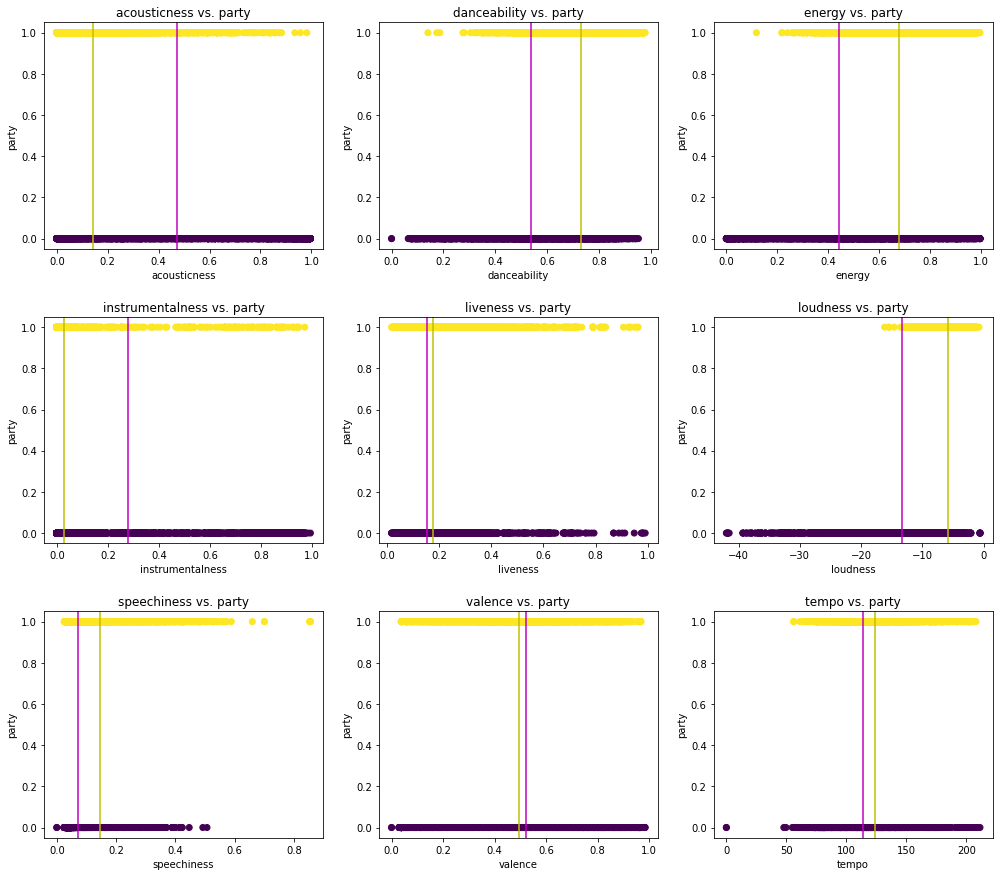

In [30]:
df = music
target = 'party'
cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'tempo']
i = 0
nRows = math.ceil(len(cols) / 3)
nCols = 3
f = plt.figure(figsize=(17,15))

for col in cols:
    i += 1
    ax = f.add_subplot(nRows * 100 + nCols * 10 + i)
    ax.scatter(df[col],df[target], c = df[target]) #np.vectorize(color_chooser)(df[target]))
    ax.axvline(np.mean(df[df[target] == 1][col]), c='y')
    ax.axvline(np.mean(df[df[target] == 0][col]), c='m')

    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(str(col) + " vs. " + target)

f.subplots_adjust(wspace = 0.2, hspace=0.3)
plt.show()

From here we compare the means of distributions from our party songs vs non party songs. On average party songs can be distinguished as having a higher danceability, higher energy, higher loudness, and a lower instrumentalness while other audio features are relatively similar between party and non party songs. From these differences, we can attempt to train a classification ML model that can learn these differences in order to predict whether a song is a good fit for the party or not.

Step 3: Training models
Having visualized the data, we now understand a little more about what kind of audio features make a "party song".  So now we wanted to choose a model that would most accuratly predict whether a song is a party or non-party song. So we want the model to predict whether a song is a party song or not, so we decided to mesaure this by having the model output a binary 1 or 0, where 1 means it is a party song and 0 means it is not a party song.  To do this, we passed in a 2 dimensional dataframe with audio feature data as the features, and a dataframe with one column, "party", which had a 1 or a 0 based on if we though it was a party song or not. Since we want to build a model that can distinguish between a party song a non party song, we looked at classification models such as K nearest neighbors, Random Tree Classifier, Logistic Regression, and Support Vector Machines. So overall, these models were trained based off of our subjective opinion of what a party song is, to predict whether a given song is considered party or not. We just want to see what model detected it the best, so that when we make your personal DJ based off your preferences, it can classify it the best.

In [33]:
#Splitting dataframe into train and testing data
features = music.drop(["track_id", "song", "party"], axis = 1)
target = music["party"]
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)
y_train = y_train.astype("int")
y_test = y_test.astype("int")

#Normalizing values
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#Training MODELS

#KNNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=5)
kNN.fit(x_train, y_train)

#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)

#Random Tree Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(x_train, y_train)

#Support vector machine
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

SVC(kernel='linear')

4) Testing the Models
We abitrairly chose models to test.  In order to compare the models we wanted to look at a few metrics for each.  First, we wanted to see how accurate the models predictions were to the y_test data.  Then to gain more insight and assert or contradict the accuracy score, we looked at the classification report and confusion matrix.  

In [16]:
#Metrics for K nearest neighbors
y_pred_kNN = kNN.predict(x_test)
print("Accuracy" + str(accuracy_score(y_test, y_pred_kNN)))
print(classification_report(y_test, y_pred_kNN))
print(confusion_matrix(y_test, y_pred_kNN))

#Metrics for Logistics regression
y_pred_lr = lr.predict(x_test)

print("Accuracy" + str(accuracy_score(y_test, y_pred_lr)))
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

#Metrics for Random Tree Classifier
y_pred_rfc = rfc.predict(x_test)

print("Accuracy" + str(accuracy_score(y_test, y_pred_rfc)))
print(classification_report(y_test, y_pred_rfc))
print(confusion_matrix(y_test, y_pred_rfc))

#Metrics for SVM
y_pred_svm = svm.predict(x_test)

print("Accuracy" + str(accuracy_score(y_test, y_pred_svm)))
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

Accuracy0.9747474747474747
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.98      0.99      0.99       187

    accuracy                           0.97       198
   macro avg       0.89      0.86      0.87       198
weighted avg       0.97      0.97      0.97       198

[[  8   3]
 [  2 185]]
Accuracy0.98989898989899
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.99      0.99       187

    accuracy                           0.99       198
   macro avg       0.92      0.99      0.96       198
weighted avg       0.99      0.99      0.99       198

[[ 11   0]
 [  2 185]]
Accuracy0.9797979797979798
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.98      0.99      0.99       187

    accuracy                           0.98       198
   

Part 5: Choosing a model
To choose a model for our DJ, we obviosly wanted the most accurate and most precise model.  When we looked through the accuracy scores, classification reports, and confusion matrices, we came to choose a logistic regression as the model for our DJ.  Although the Random Tree and K nearest neighbors has 97 and 98 percent accuracies, the logistic regression had a 99 percent accuracy.  Also if we look at the precision of classification, the logistic regression predicted 100 percent of party songs correctly.  This means that of the songs returned by the DJ, all party songs will at least be there, with some exceptions of incorrect predictions of non-party songs.  

OKAY, now we have selected a model in which to build our DJ class around. In discjockey.py, we have encapsulated a content based recommender using a logistic regression model. You can pass this DJ your own party preferences, and it will be able to learn your party preferences from that playlist against the preset data of non party music we built. 

Look at README.md to learn more about what this DJ can now do!